# Libs

In [3]:
!pip3 install minisom 
!pip3 install tslearn
!pip3 install pandas
!pip3 install yfinance
!pip3 install seaborn
!pip3 install plotly
!pip3 install pandas_datareader


import numpy as np
import matplotlib
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import requests

import plotly as pl
from plotly.offline import init_notebook_mode , iplot 
init_notebook_mode(connected = True)
import plotly.graph_objs as go

import datetime    
import sys      
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
 

from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import seaborn as sns
sns.set_style("whitegrid")


import pandas_datareader as pdr
import datetime
import os
import yfinance as yf
import time


#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#baseDataPath  = 'drive/MyDrive/Drive/MSc/Dissertation/StocksData/'

baseDataPath  = '/Users/nenuadrian/Desktop/StocksData/'

# Overview


Stock prices are a reflection of the health and performance of a company, and understanding their fluctuations and trends can be important for investors and traders. One way to analyze stock prices is through time series clustering and K-means clustering to time series.

Time series clustering is a method of grouping similar time series data based on their patterns and trends. This can be useful for identifying different stages or phases of a company's performance, such as a period of growth or decline. By comparing the patterns of different stocks, investors and traders can gain insights into the performance of different companies and industries, and make informed decisions about where to invest their money.

K-means clustering is a specific method of time series clustering that involves partitioning the data into K clusters, where K is a user-specified parameter. This algorithm groups similar time series based on their similarity in terms of their means and variances. K-means can be applied to different stock metrics such as stock prices, trading volumes, and market capitalization.

By using K-means clustering, investors and traders can identify patterns in the performance of different stocks and industries. For example, they can see which stocks have similar patterns of growth or decline, and which industries have been more affected than others by market conditions. This can help inform investment decisions and portfolio management.

In addition, K-means can also be used to identify subgroups within an industry that have been affected differently by market conditions. For instance, it can be used to identify stocks with high volatility, high trading volume, or high market capitalization. This can help investors and traders understand how different factors are affecting the performance of different stocks and make more informed decisions about where to invest their money.

Overall, time series clustering and K-means clustering to time series can be powerful tools for analyzing stock prices. By identifying patterns and trends in the performance of different stocks and industries, investors and traders can gain insights that can inform their investment decisions and help them navigate the financial markets. It is important to note that this should be used in conjunction with other fundamental analysis and technical analysis to make an informed decision.


# Exploratory

## Dump Ticker Stock Data

In [4]:
tickersNasdaq = pd.read_csv(f"{baseDataPath}nasdaq100-01.2023.csv")
tickersSp = pd.read_csv(f"{baseDataPath}sp500-01.2023.csv")
tickersData = pd.concat([tickersNasdaq[:100], tickersSp[:100]])
tickersData = tickersData[["Company", "Symbol"]]

tickersData

Company Symbol
0                        Microsoft Corp   MSFT
1                             Apple Inc   AAPL
2                        Amazon.com Inc   AMZN
3                          Alphabet Inc   GOOG
4                          Alphabet Inc  GOOGL
..                                  ...    ...
95                     Altria Group Inc     MO
96  Vertex Pharmaceuticals Incorporated   VRTX
97              Duke Energy Corporation    DUK
98                   EOG Resources Inc.    EOG
99       Regeneron Pharmaceuticals Inc.   REGN

[200 rows x 2 columns]

In [5]:
# Define the ticker symbols for the top Fortune 500 companies
tickers = tickersData["Symbol"].unique()

print(f"{len(tickers)} tickers to consider based on loaded data")

# Define the start and end dates for the data
start = "2017-01-01"
end = "2023-01-01"

# create a folder to store the csv files
if not os.path.exists(f"{baseDataPath}csv_files"):
    os.mkdir(f"{baseDataPath}csv_files")

for ticker in tickers:
  if not os.path.exists(f"{baseDataPath}csv_files/{ticker}.csv"):
    # Download the data for each company
    data = yf.download(ticker, start=start, end=end)
    # Create a CSV file for each company
    data.to_csv(f"{baseDataPath}csv_files/{ticker}.csv")
    print(f"{ticker} data exported to csv_files/{ticker}.csv")

166 tickers to consider based on loaded data


In [6]:
api_key = "cb34a7e240c14100e23c44822df4e258"

companyData = pd.read_csv(f"{baseDataPath}company-data3.csv")
for filename in os.listdir(f"{baseDataPath}csv_files"):
  if filename.endswith(".csv"):
    # Replace <stock_symbol> with the actual stock symbol
    stock_symbol = filename[:-4]
    if stock_symbol in tickers:
      if companyData is None or companyData.empty or len(companyData.loc[companyData['symbol'] == stock_symbol]) == 0:
        # Make the request to the API
        print(f"Downloaded data for {stock_symbol}")
        response = requests.get(f'https://financialmodelingprep.com/api/v3/profile/{stock_symbol}?apikey={api_key}')
        if companyData is None:
          companyData = [response.json()[0]]
          companyData = pd.DataFrame.from_records(companyData)
        else: 
          newRow = pd.DataFrame.from_records([response.json()[0]])
          companyData = pd.concat([companyData, newRow])
        companyData.to_csv(f"{baseDataPath}company-data3.csv") 

companyData = companyData[~pd.isnull(companyData['symbol'])]

companyData["symbol"]

Downloaded data for BRK.B


0       AAPL
1        WMT
2       AMZN
3      GOOGL
4       META
       ...  
168    BRK-B
169    BRK-B
170    BRK-B
171    BRK-B
0      BRK-B
Name: symbol, Length: 173, dtype: object

## Parse Downloaded Stock Files

In [7]:
mySeries = []
namesofMySeries = []
for filename in os.listdir(f"{baseDataPath}csv_files"):
    if filename.endswith(".csv"):
        df = pd.read_csv(f"{baseDataPath}csv_files/"+filename)
        if not df.empty:
          if filename[:-4] in tickers:
            df = df.loc[:,["Date","Close"]]
            df["Close"] = df["Close"].replace("[$,]", "", regex=True).astype(float)
            df.set_index("Date",inplace=True)
            df.sort_index(inplace=True)
            mySeries.append(df)
            namesofMySeries.append(filename[:-4])

print("Files parsed: " + str(len(namesofMySeries)))

dataOfMySeries = []
for n in namesofMySeries:
  data = companyData[companyData["symbol"] == n]
  dataOfMySeries.append(data)

print("Data found: " + str(len(dataOfMySeries)))

Files parsed: 165
Data found: 165


## Explore

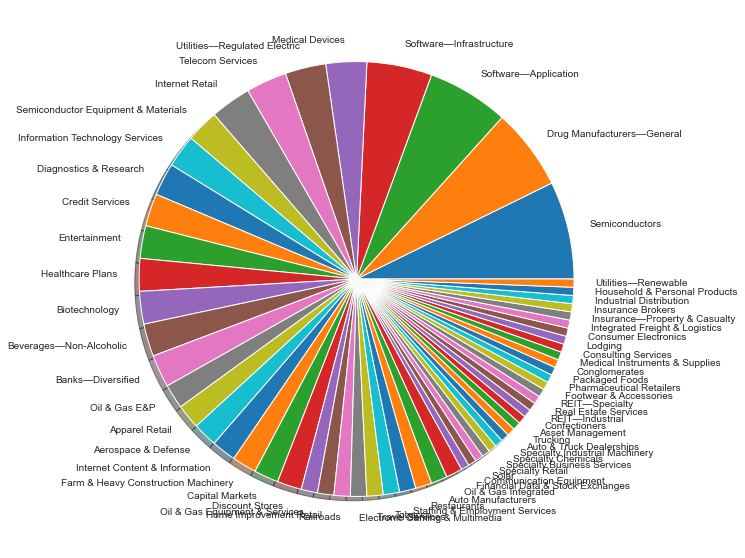

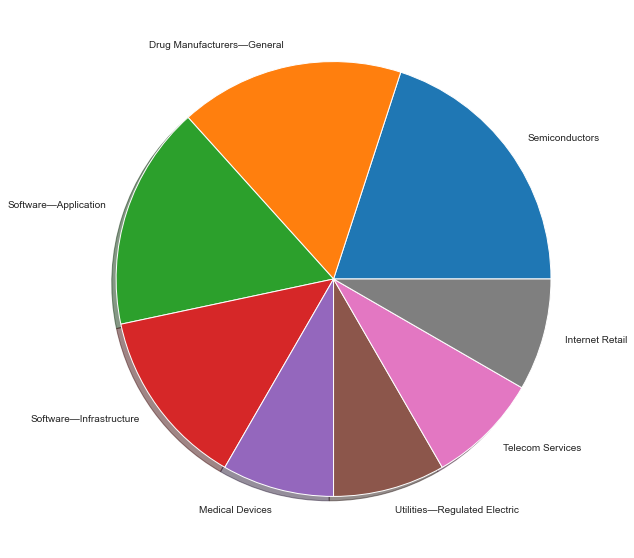

In [72]:
industries = pd.DataFrame(([d["industry"].values[0] for d in dataOfMySeries]),columns=["Industry"]).groupby("Industry")["Industry"].count().sort_values(ascending=False).reset_index(name='count')
plt.figure(figsize=(10,10))

plt.pie(industries["count"], labels = industries["Industry"], shadow = True)
plt.show() 


industries = industries[industries["count"] >= 5]

plt.figure(figsize=(10,10))

plt.pie(industries["count"], labels = industries["Industry"], shadow = True)

plt.show()

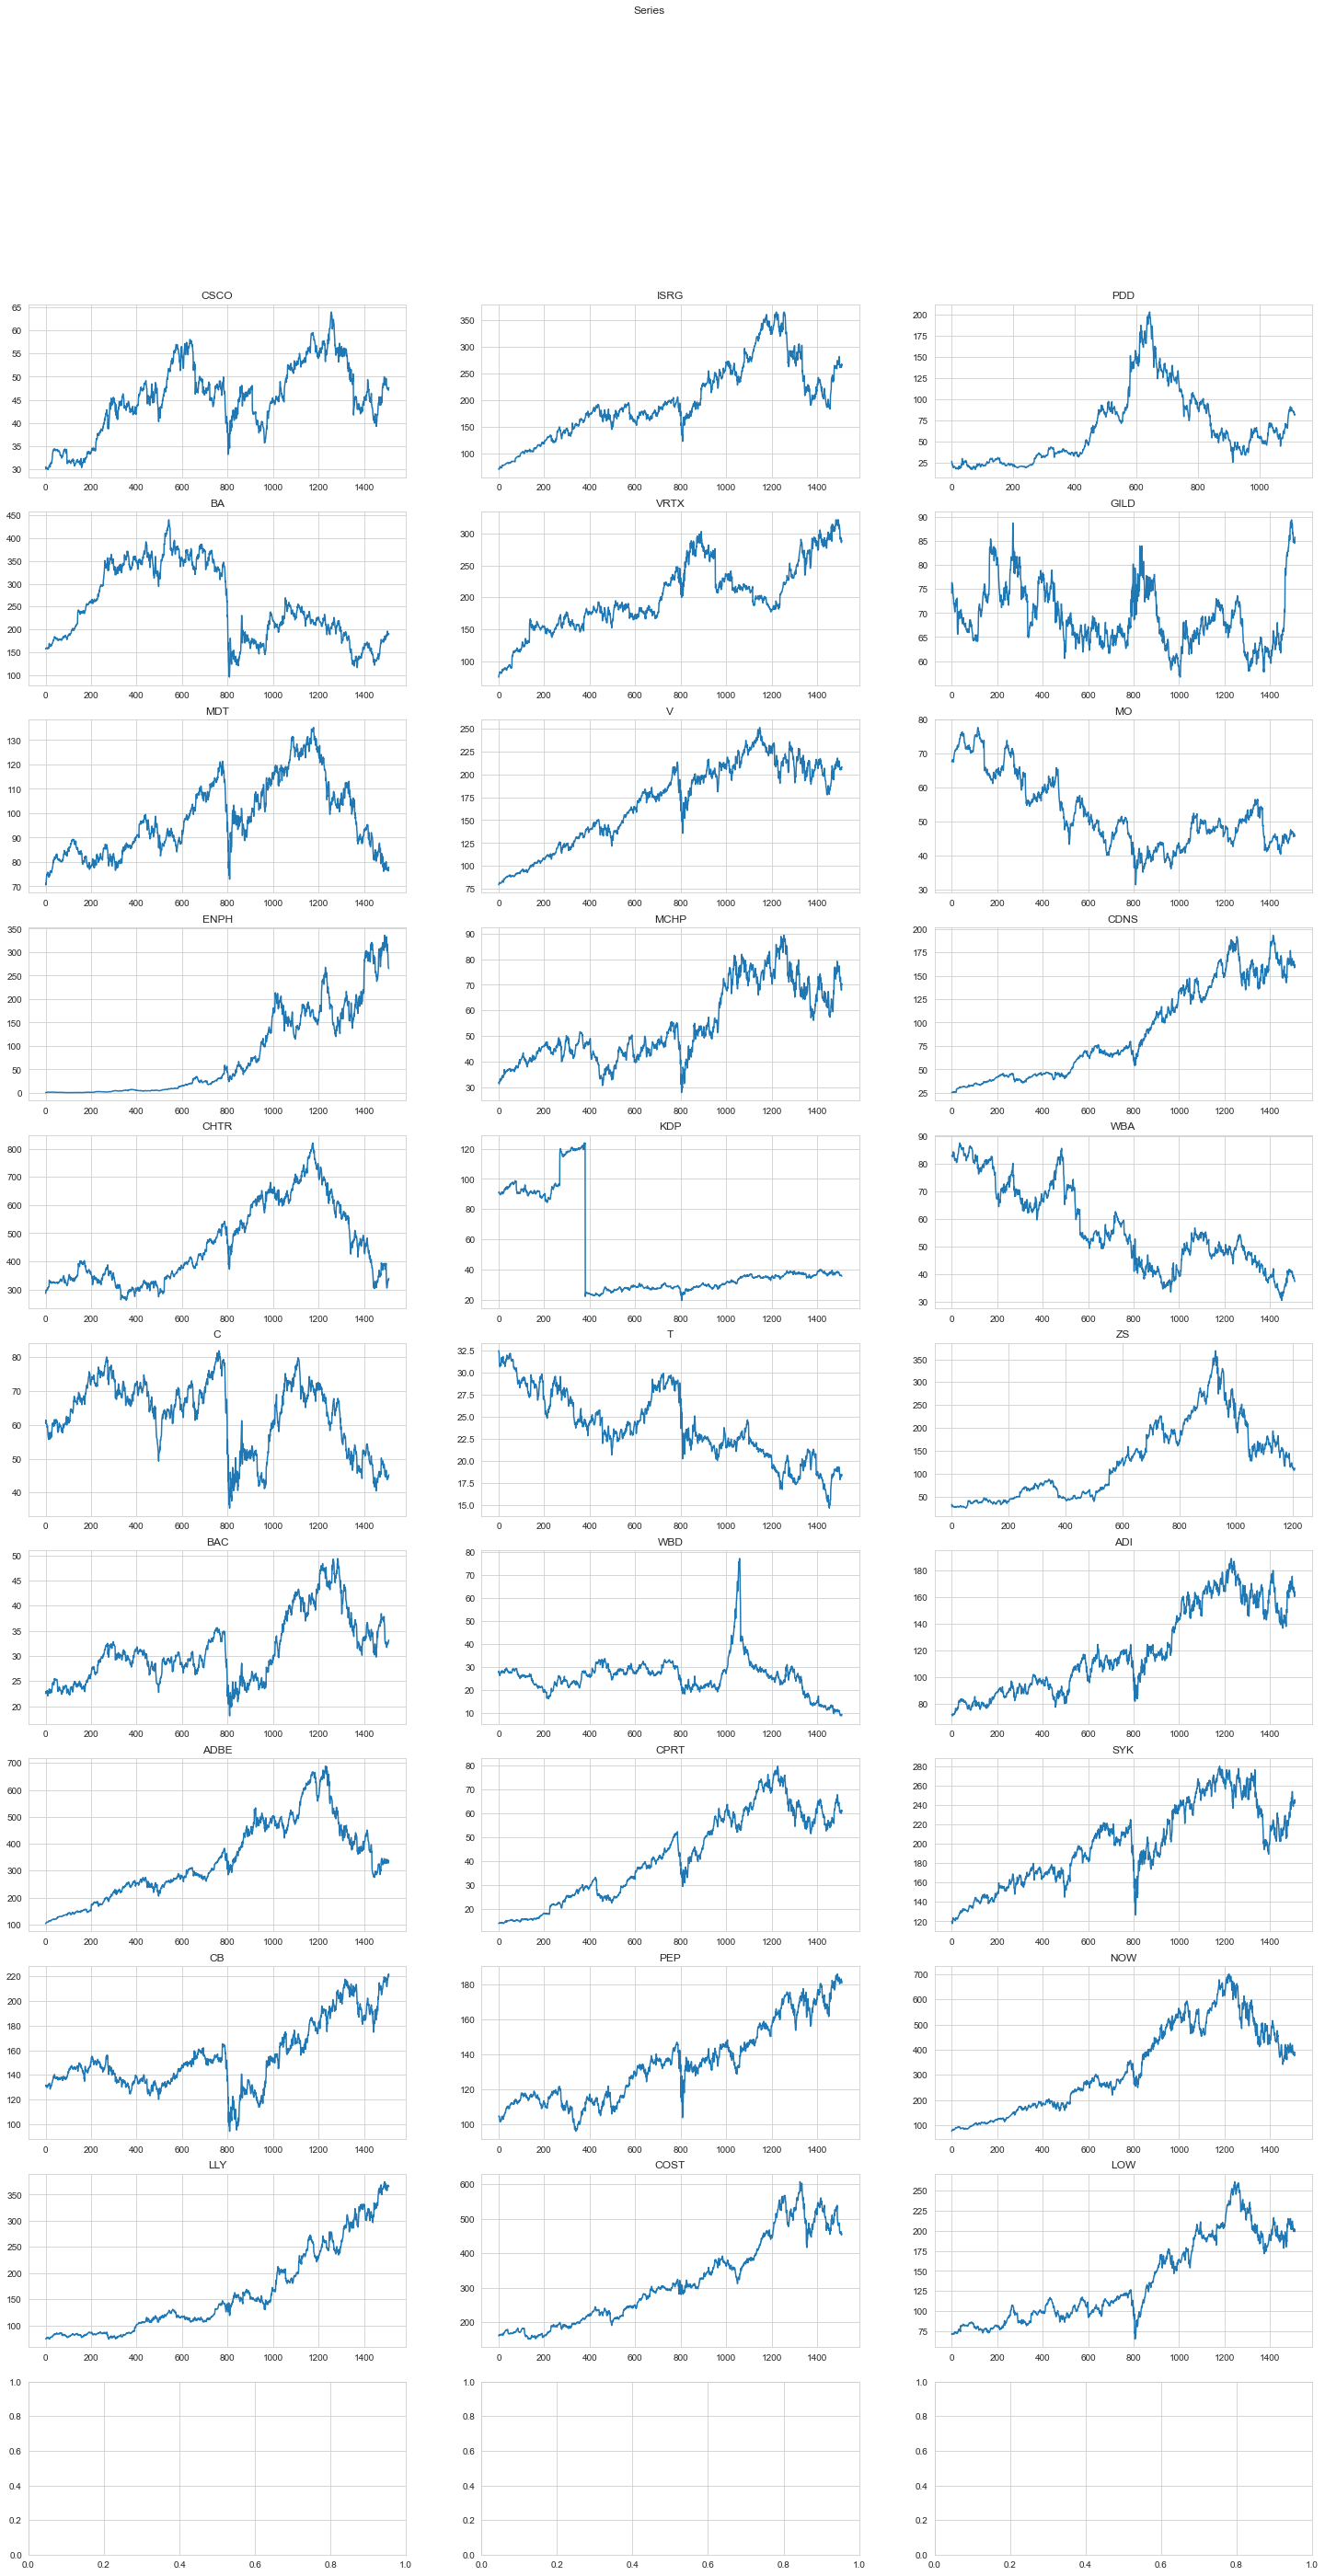

In [9]:
plotSeries = mySeries[:30]
fig, axs = plt.subplots(math.floor(len(plotSeries) / 3) + 1,3,figsize=(25,45))
fig.suptitle('Series')
for i in range(math.floor(len(plotSeries) / 3) + 1):
  for j in range(3):
      if i*3+j+1>len(plotSeries): # pass the others that we can't fill
          continue
      axs[i, j].plot(plotSeries[i*3+j].values)
      axs[i, j].set_title(namesofMySeries[i*3+j])
plt.show()

# ML Initial

## MiniSom

In [10]:

'''
series_lengths = {len(series) for series in mySeries}

max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)



nan_counter(mySeries)
'''

def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)
    
print(f"Total series before filtering to keep only those that have data for require timeframe: {len(mySeries)}")

mySeries = [series for series in mySeries if series.index[0][0:10] == "2017-01-03"]
mySeries = [series for series in mySeries if series.index[len(series.values) - 1][0:10] == "2022-12-30"]

print(f"Total series before filtering to keep only those that have data for require timeframe: {len(mySeries)}")

nan_counter(mySeries)

for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i] = mySeries[i].reshape(len(mySeries[i]))


Total series before filtering to keep only those that have data for require timeframe: 165
Total series before filtering to keep only those that have data for require timeframe: 155
0


In [11]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y, len(mySeries[0]), sigma=0.3, learning_rate = 0.1, random_seed=1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

### plot_som_series_averaged_center

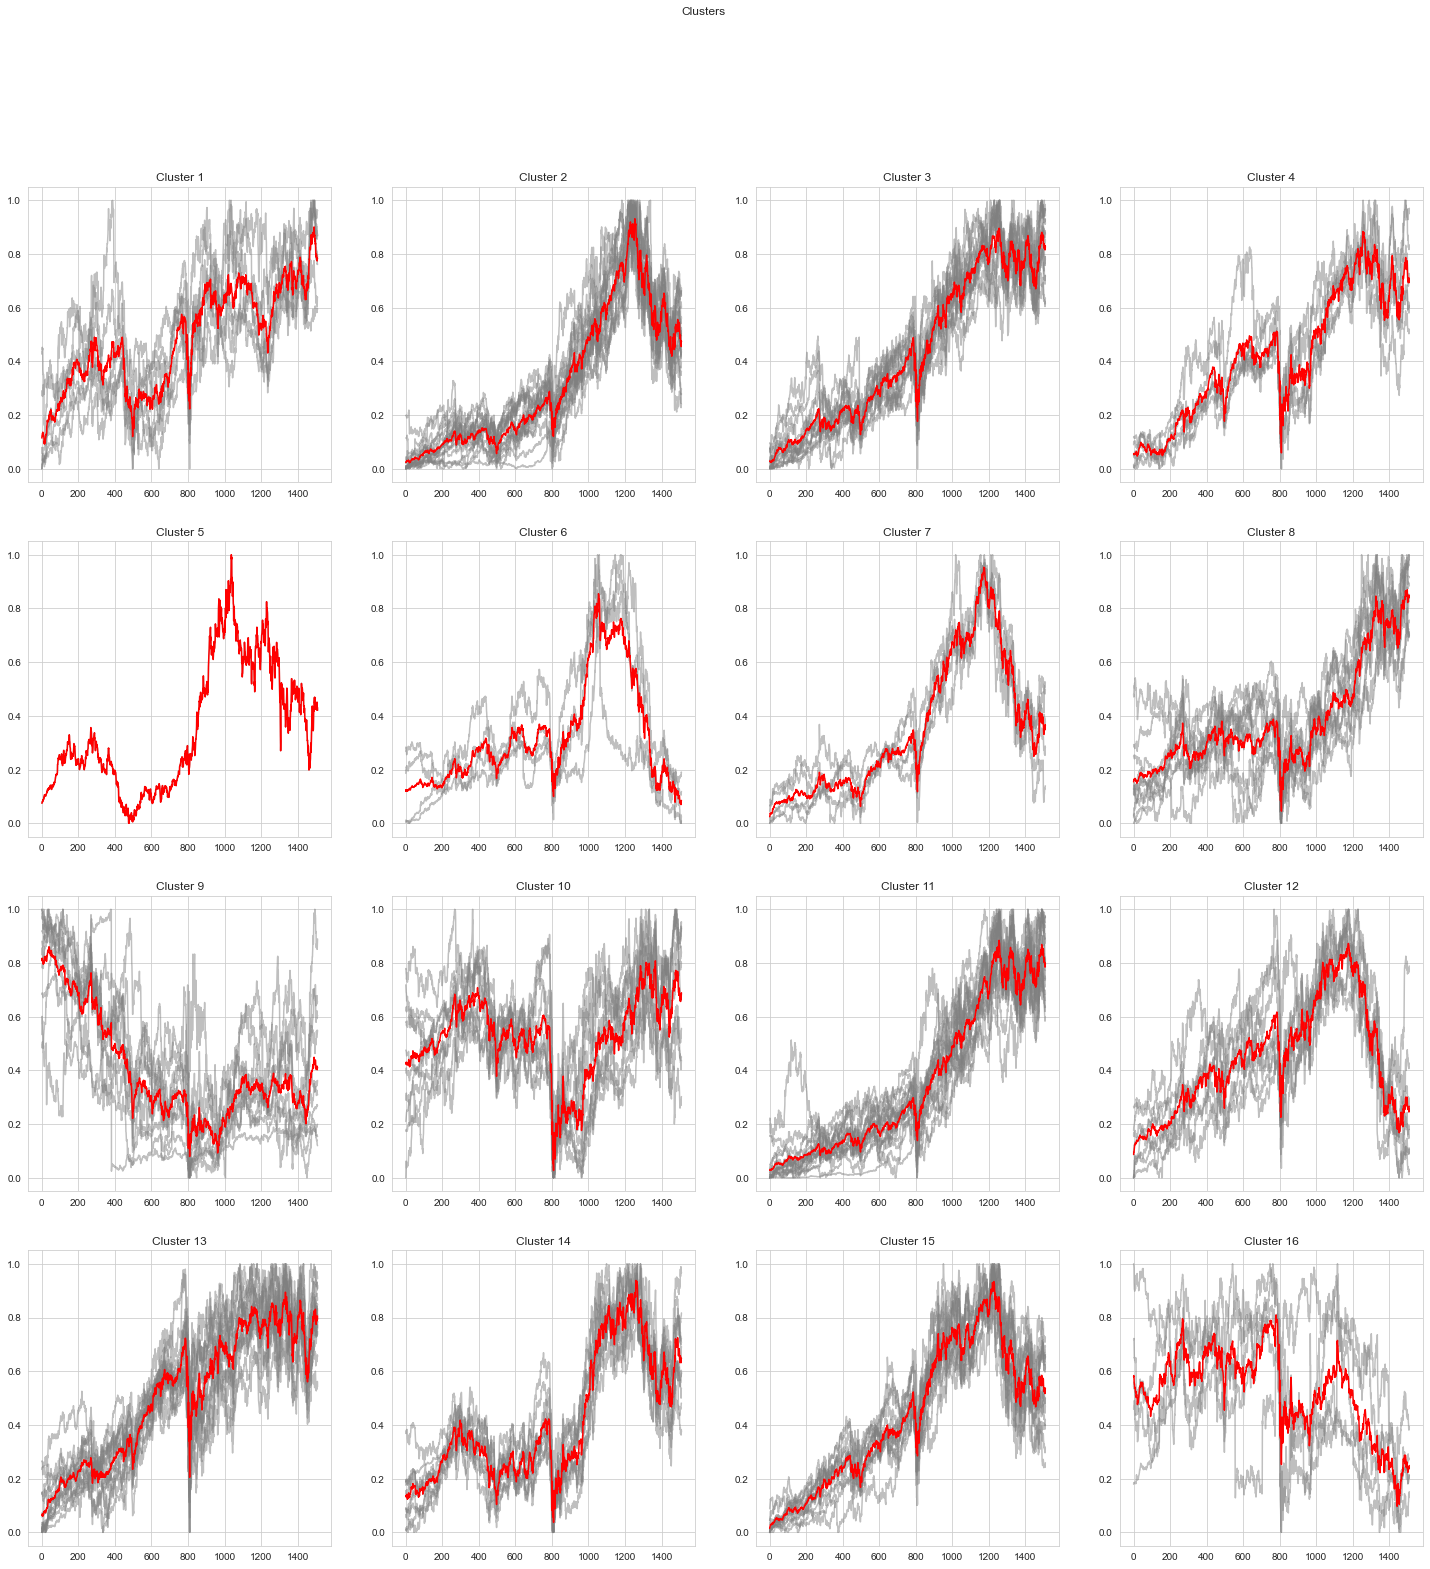

In [12]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

win_map = som.win_map(mySeries)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

### plot_som_series_dba_center

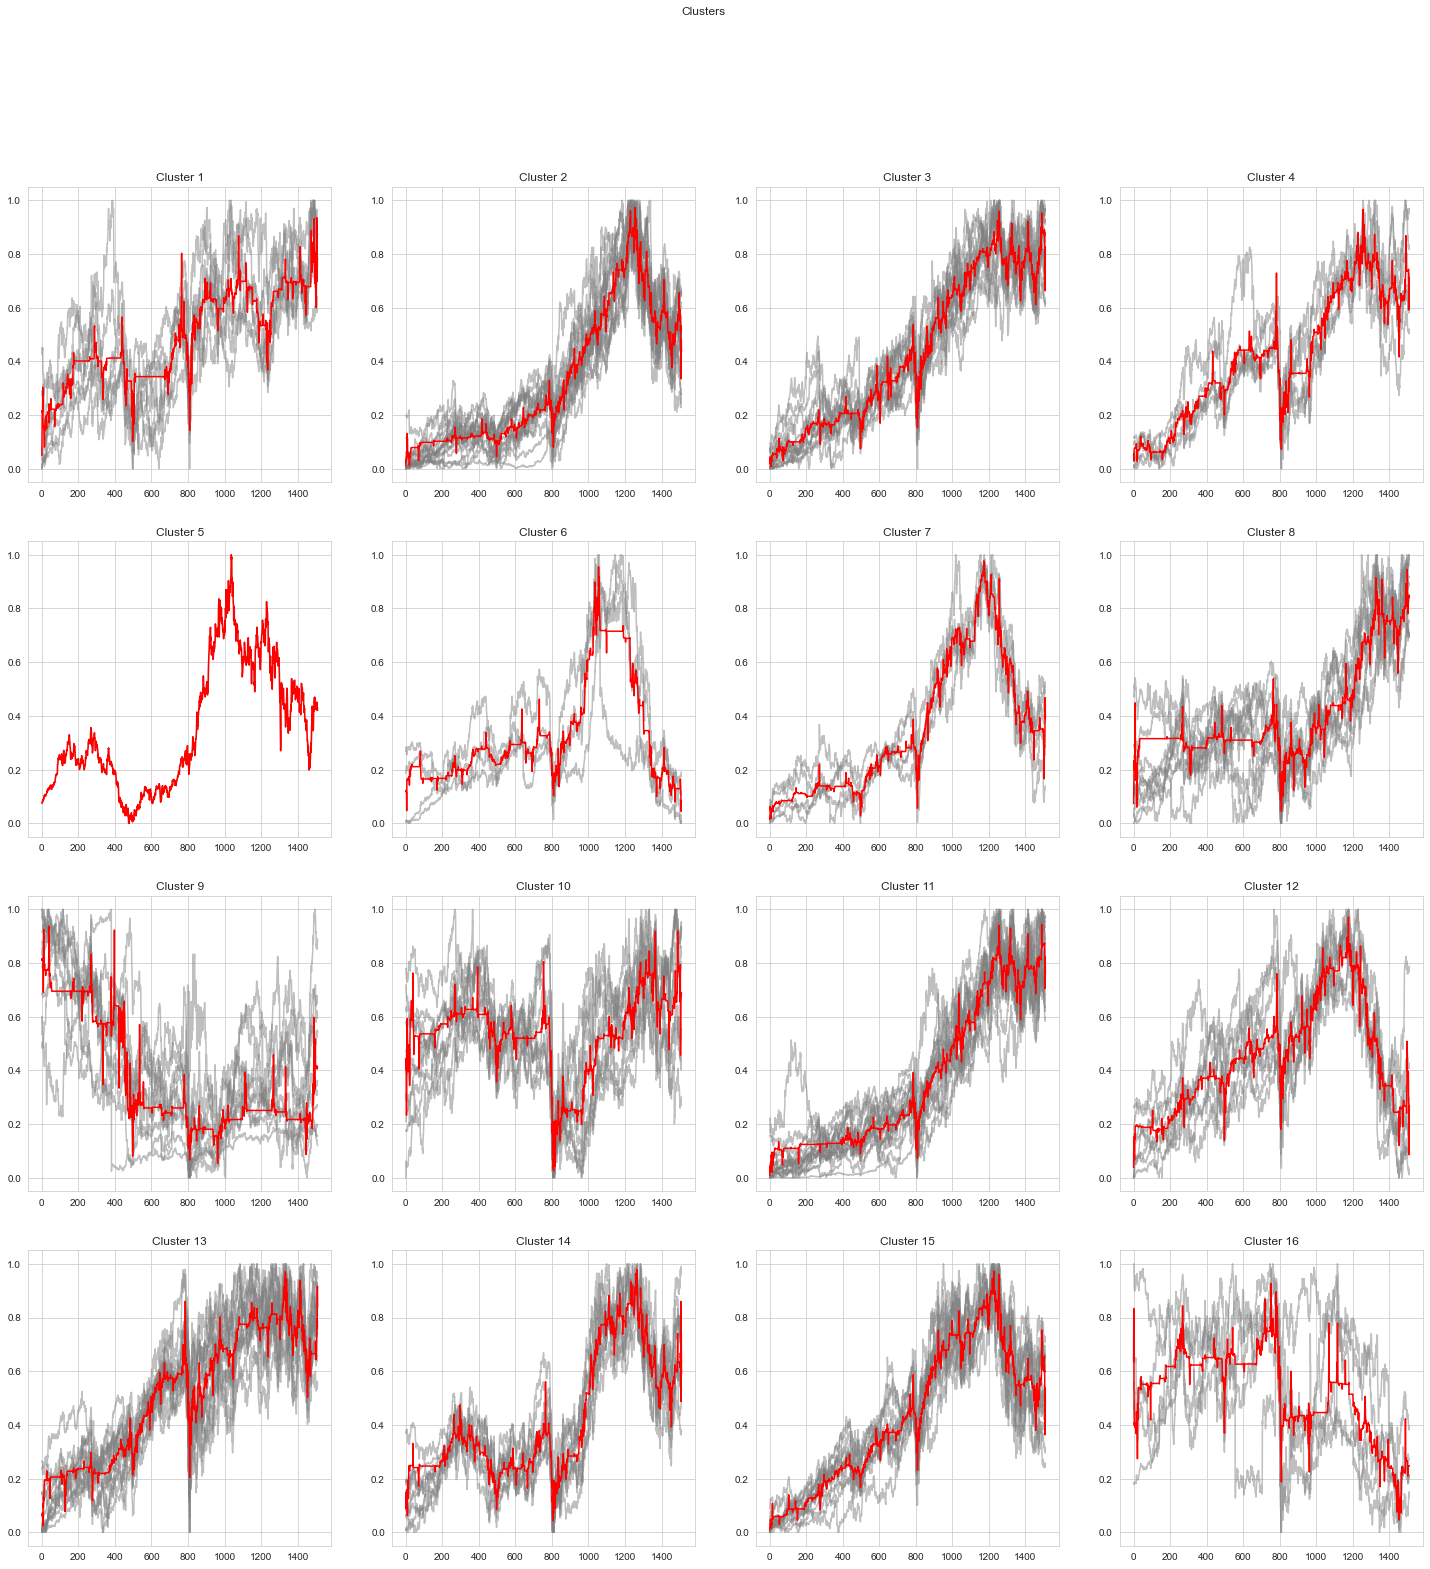

In [13]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

win_map = som.win_map(mySeries)

plot_som_series_dba_center(som_x, som_y, win_map)

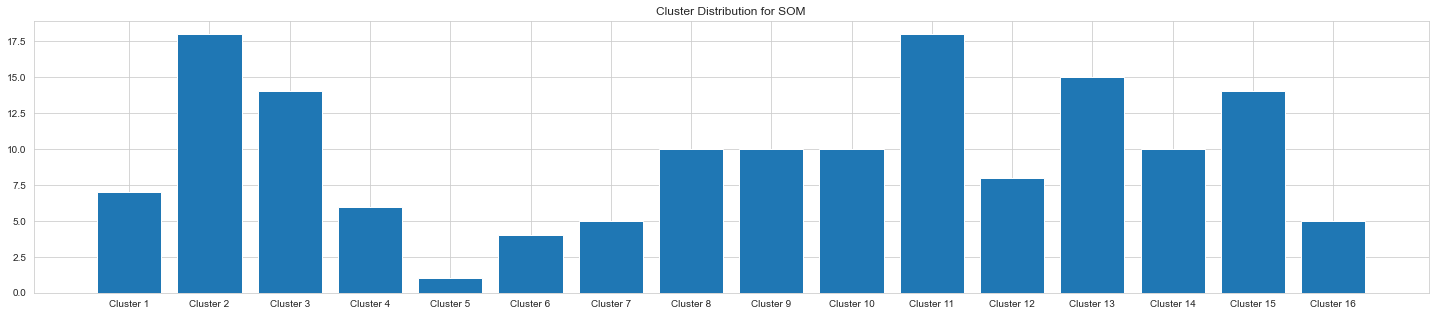

In [14]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()


In [48]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    industry = dataOfMySeries[idx]["industry"].values[0]
    

    cluster_map.append((namesofMySeries[idx], f"Cluster {winner_node[0]*som_y+winner_node[1]+1}", industry, idx))

clusters = pd.DataFrame(cluster_map,columns=["Series","Cluster", "Industry", "Idx"]).sort_values(by="Cluster").set_index("Series")

clusters

Cluster                     Industry  Idx
Series                                             
MELI    Cluster 1              Internet Retail   59
BA      Cluster 1          Aerospace & Defense    3
SNPS    Cluster 1      Software—Infrastructure  128
ANSS    Cluster 1         Software—Application   69
CTAS    Cluster 1  Specialty Business Services   70
...           ...                          ...  ...
CHTR    Cluster 9             Telecom Services   12
V       Cluster 9              Credit Services    7
VRTX    Cluster 9                Biotechnology    4
MS      Cluster 9              Capital Markets  139
NKE     Cluster 9       Footwear & Accessories   94

[155 rows x 3 columns]

### Explore

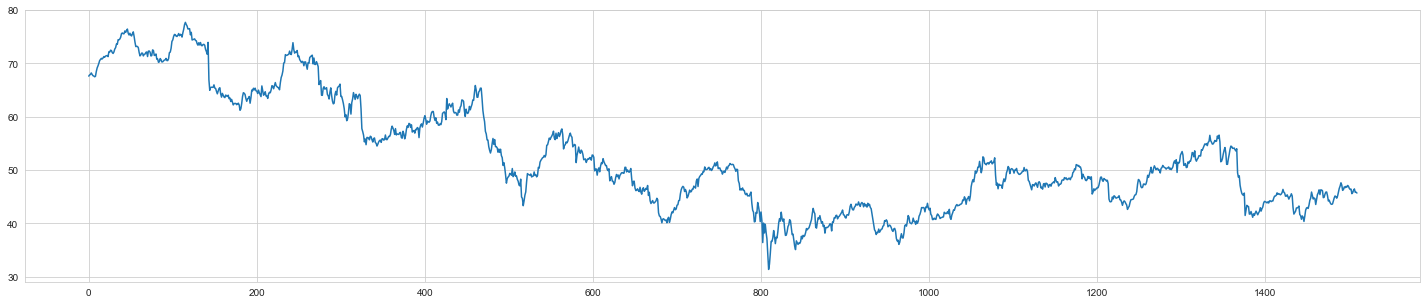

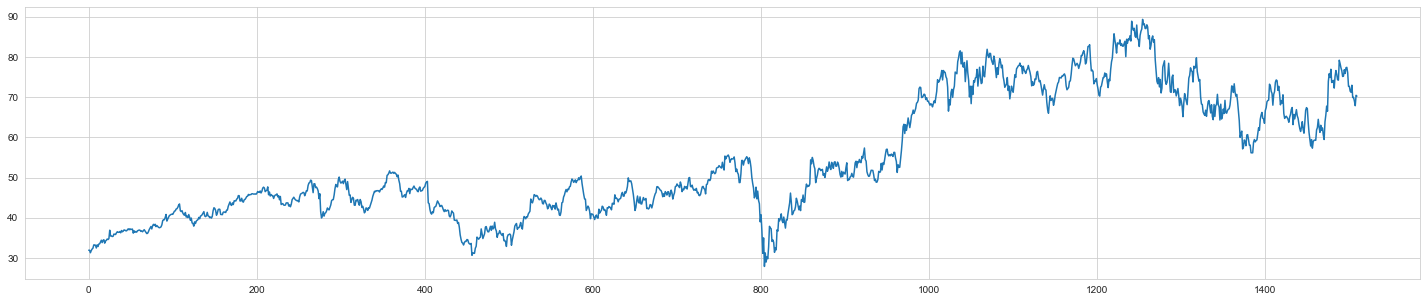

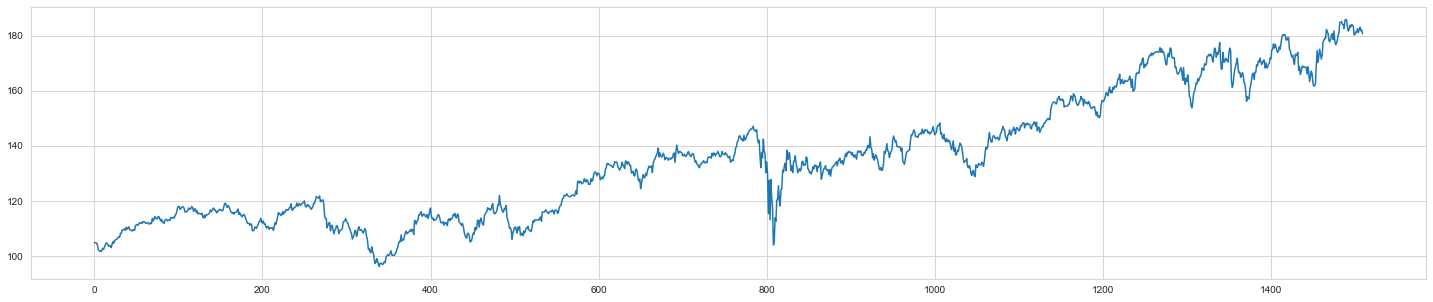

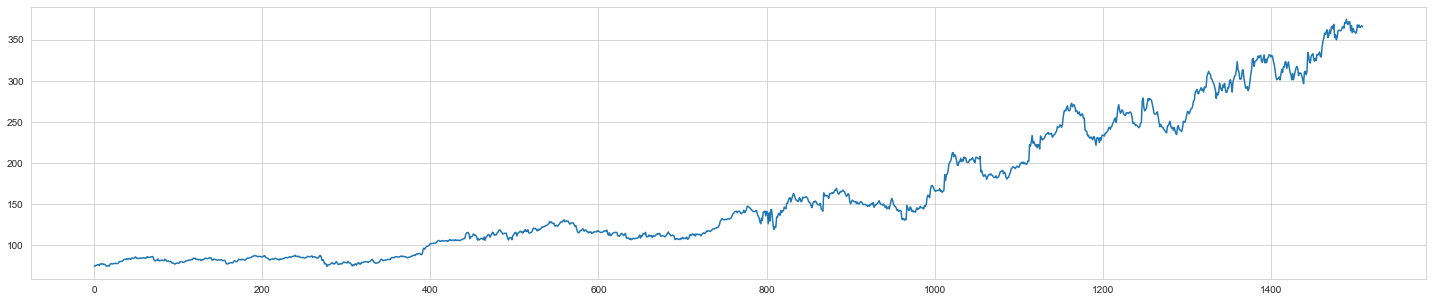

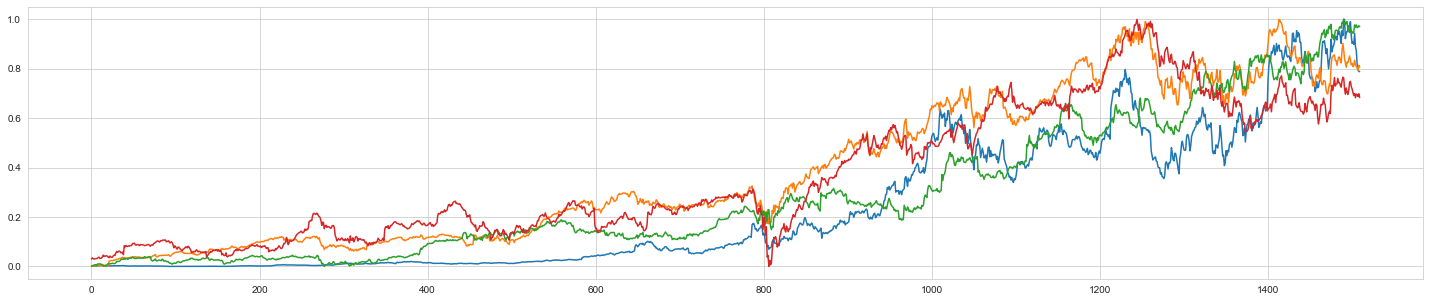

Cluster                         Industry  Idx
Series                                                  
LLY     Cluster 11       Drug Manufacturers—General   27
TXN     Cluster 11                   Semiconductors   56
PAYX    Cluster 11   Staffing & Employment Services  121
GOOGL   Cluster 11   Internet Content & Information  120
MMC     Cluster 11                Insurance Brokers  124
JD      Cluster 11                  Internet Retail  126
DHR     Cluster 11           Diagnostics & Research  118
VZ      Cluster 11                 Telecom Services  134
NOW     Cluster 11             Software—Application   26
ZM      Cluster 11             Software—Application  140
LULU    Cluster 11                   Apparel Retail  103
MO      Cluster 11                          Tobacco    8
MCHP    Cluster 11                   Semiconductors   10
PEP     Cluster 11          Beverages—Non-Alcoholic   25
ATVI    Cluster 11   Electronic Gaming & Multimedia   73
AMT     Cluster 11                   REIT—Specialty   45
ACN     Cluster 11  Information Technology Services   71
JPM     Cluster 11                Banks—Diversified  113

In [64]:
'''
plotSeries = mySeries[:30]
fig, axs = plt.subplots(math.floor(len(plotSeries) / 3) + 1,3,figsize=(25,45))
fig.suptitle('Series')
for i in range(math.floor(len(plotSeries) / 3) + 1):
  for j in range(3):
      if i*3+j+1>len(plotSeries): # pass the others that we can't fill
          continue
      axs[i, j].plot(plotSeries[i*3+j].values)
      axs[i, j].set_title(namesofMySeries[i*3+j])
plt.show()
'''

plt.figure(figsize=(25,5))
plt.plot(plotSeries[8].values)
plt.show()
plt.figure(figsize=(25,5))

plt.plot(plotSeries[10].values)
plt.show()
plt.figure(figsize=(25,5))

plt.plot(plotSeries[25].values)
plt.show()
plt.figure(figsize=(25,5))

plt.plot(plotSeries[27].values)
plt.show()

plt.figure(figsize=(25,5))

plt.plot(mySeries[8])
plt.plot(mySeries[10])
plt.plot(mySeries[25])
plt.plot(mySeries[27])
plt.show()

clusters[clusters["Cluster"] == "Cluster 11"]



## K-means

### TimeSeriesKMeans

In [16]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw",random_state=1)

# elbow method - to check for sweet spot number of clusters: play with init https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html

labels = km.fit_predict(mySeries)

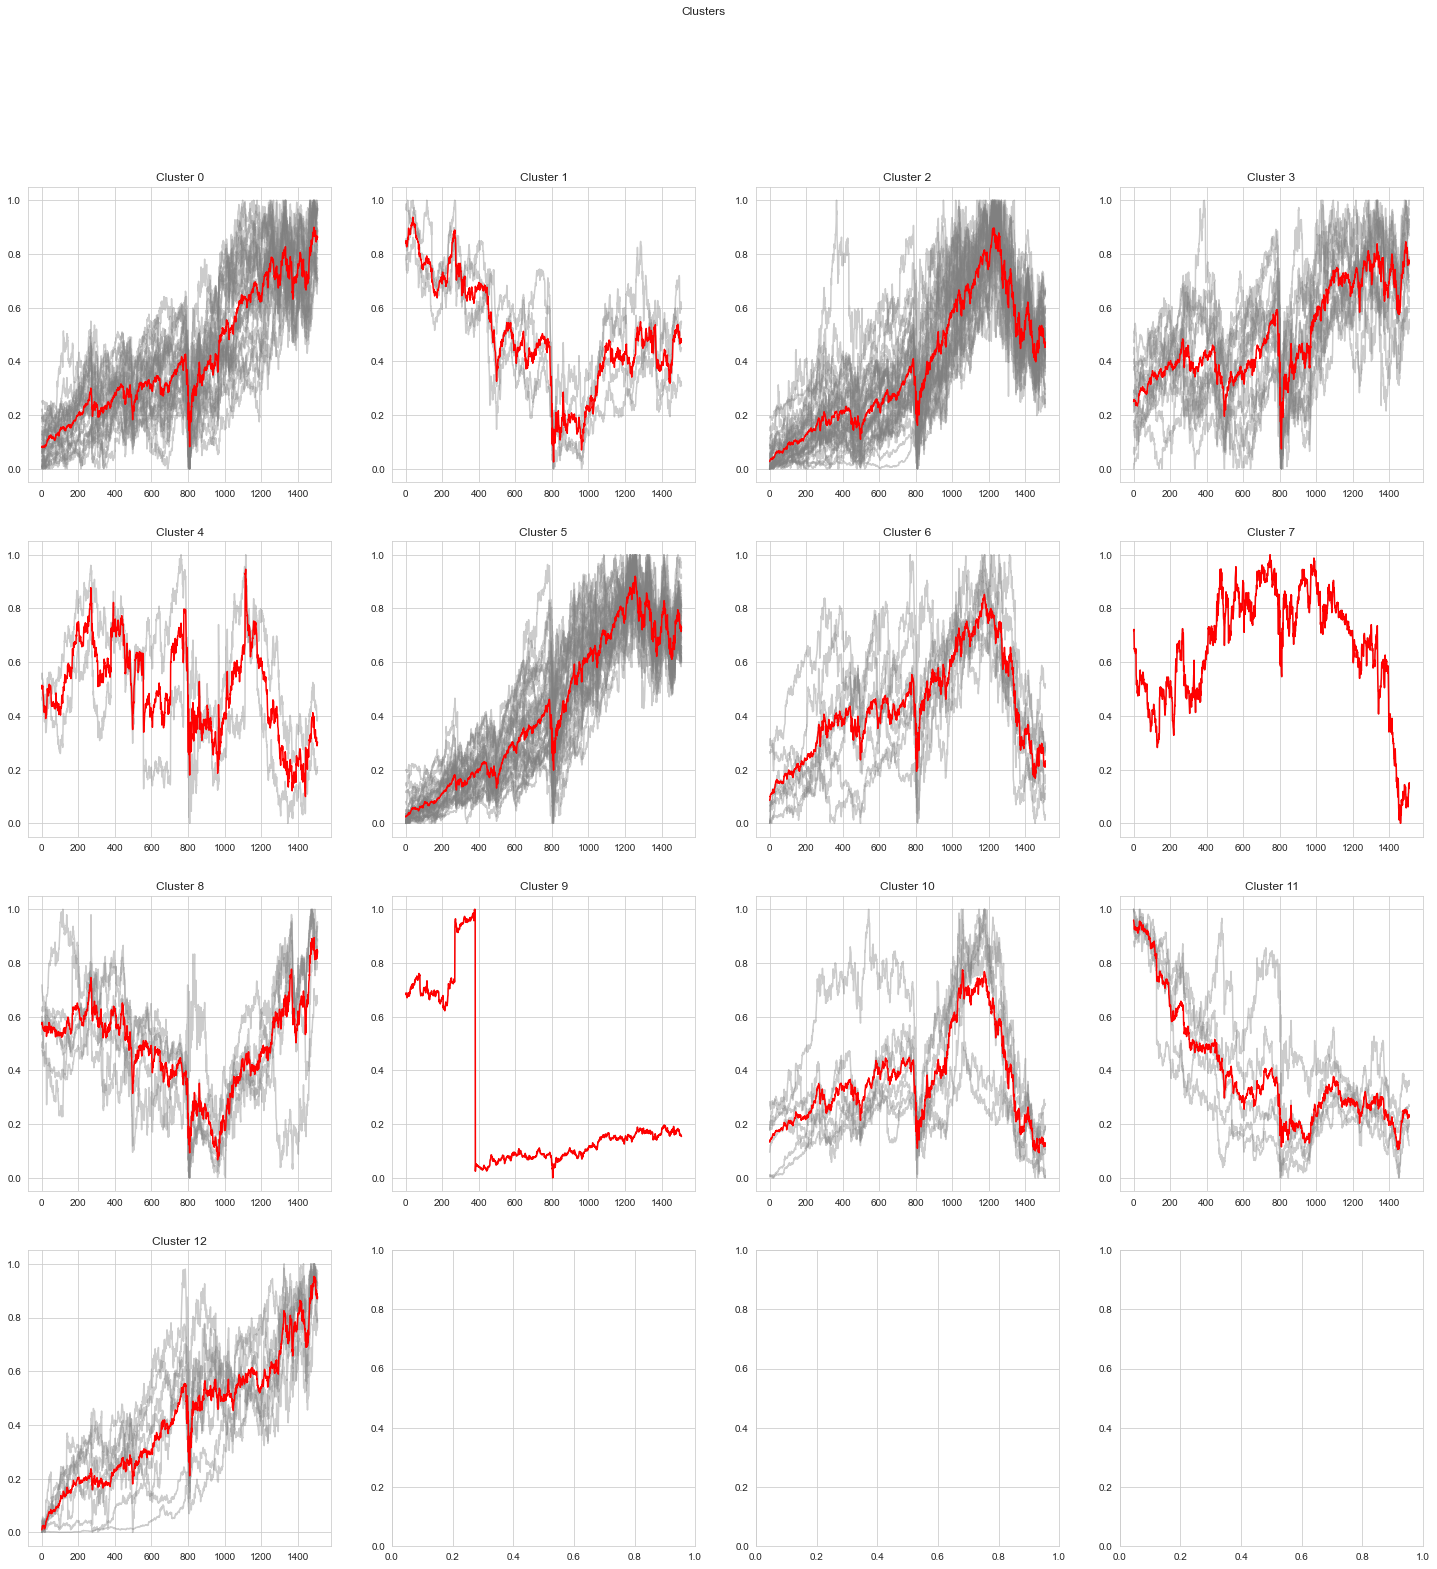

In [17]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

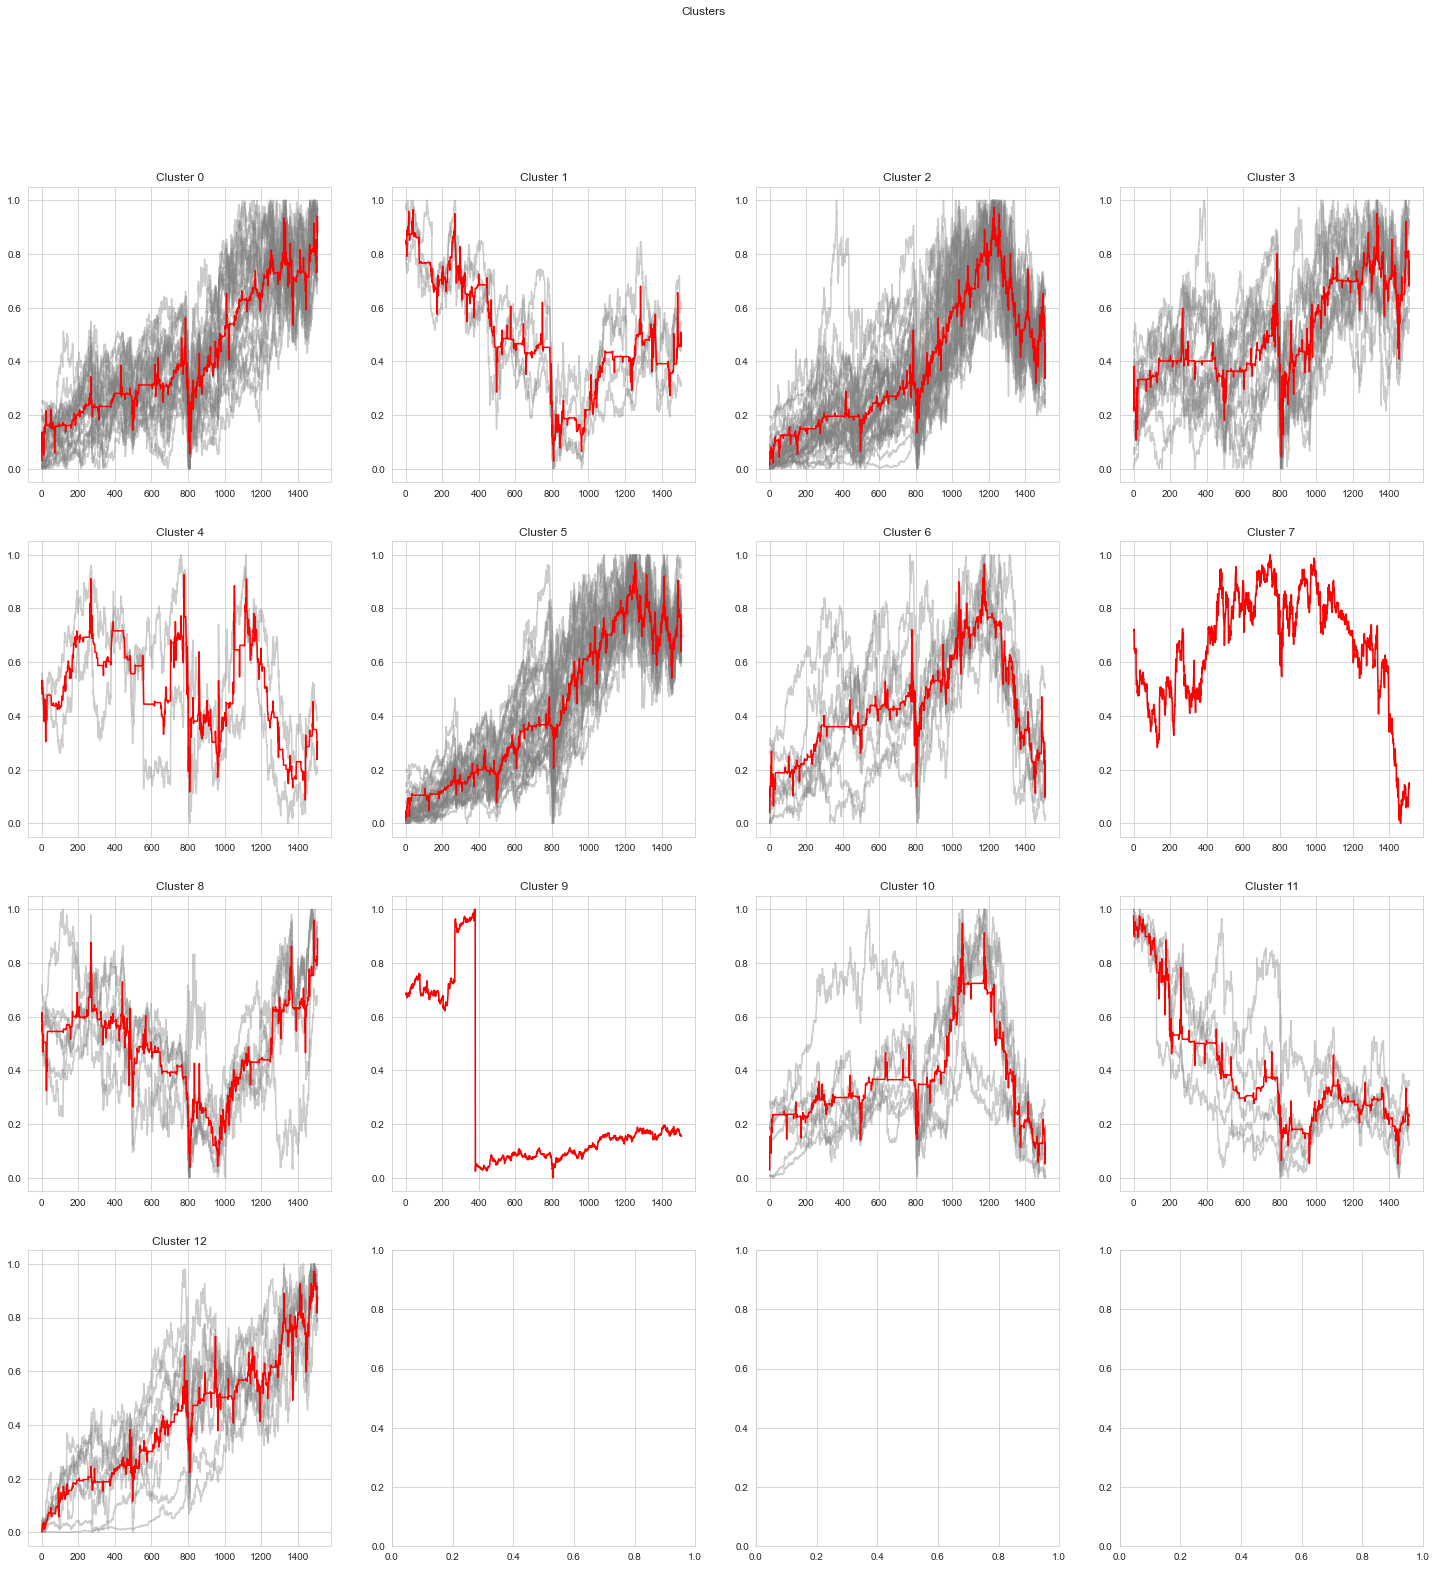

In [18]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
        
plt.show()

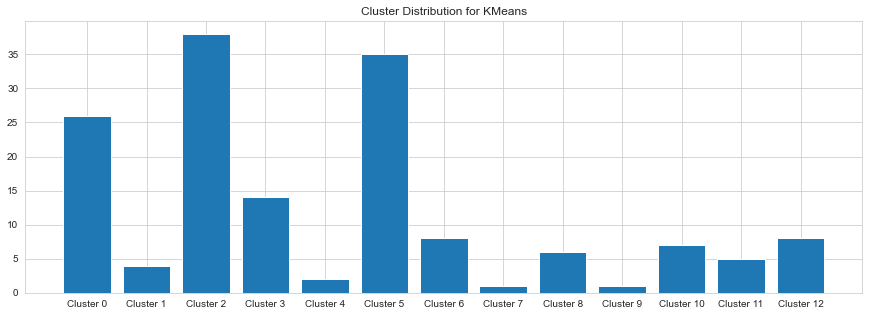

In [19]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [20]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels, [d["industry"].values[0] for d in dataOfMySeries]),columns=["Series","Cluster", "Industry"]).sort_values(by="Cluster").set_index("Series")


Cluster                             Industry
Series                                                
NVDA    Cluster 0                       Semiconductors
GOOGL   Cluster 0       Internet Content & Information
WDAY    Cluster 0                 Software—Application
XEL     Cluster 0         Utilities—Regulated Electric
PCAR    Cluster 0  Farm & Heavy Construction Machinery
...           ...                                  ...
PLD     Cluster 8                      REIT—Industrial
SPGI    Cluster 8     Financial Data & Stock Exchanges
VRTX    Cluster 8                        Biotechnology
SCHW    Cluster 8                      Capital Markets
CHTR    Cluster 9                     Telecom Services

[155 rows x 2 columns]

### Principal component analysis (PCA)

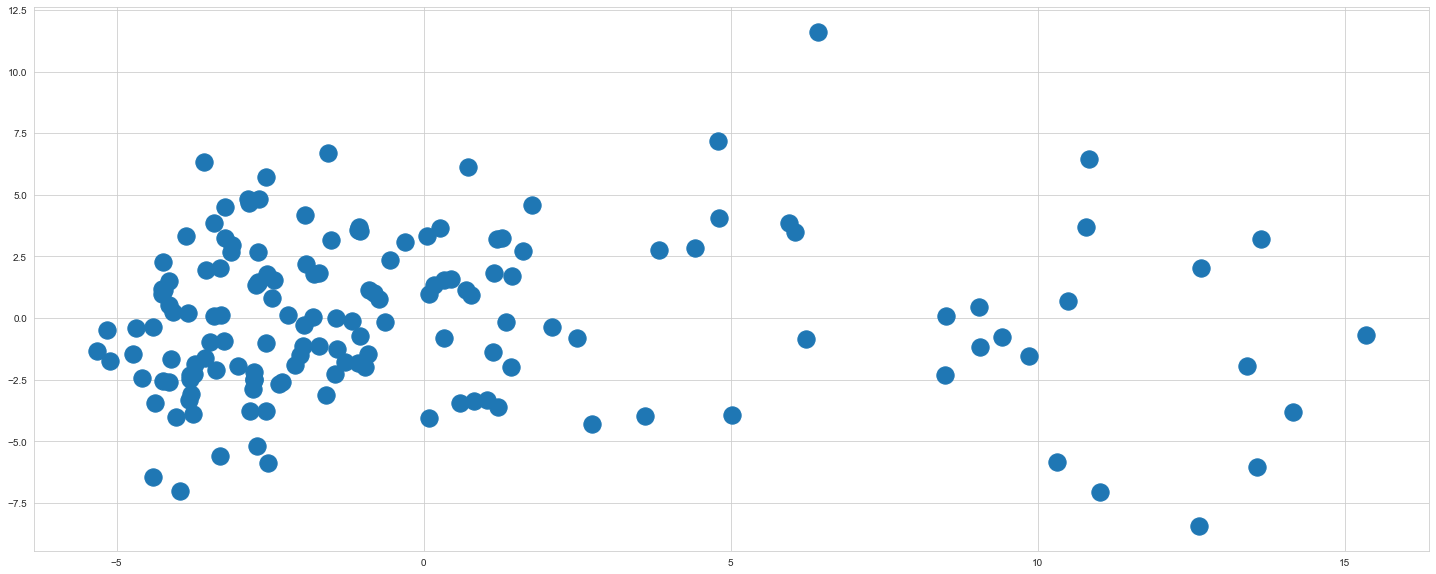

In [21]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(mySeries)

plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


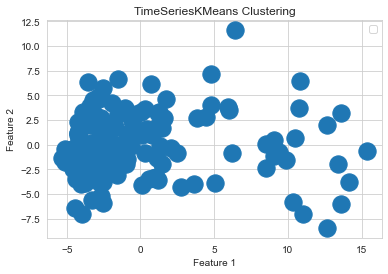

In [22]:
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], s=300)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title("TimeSeriesKMeans Clustering")
plt.show()

### KMeans

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



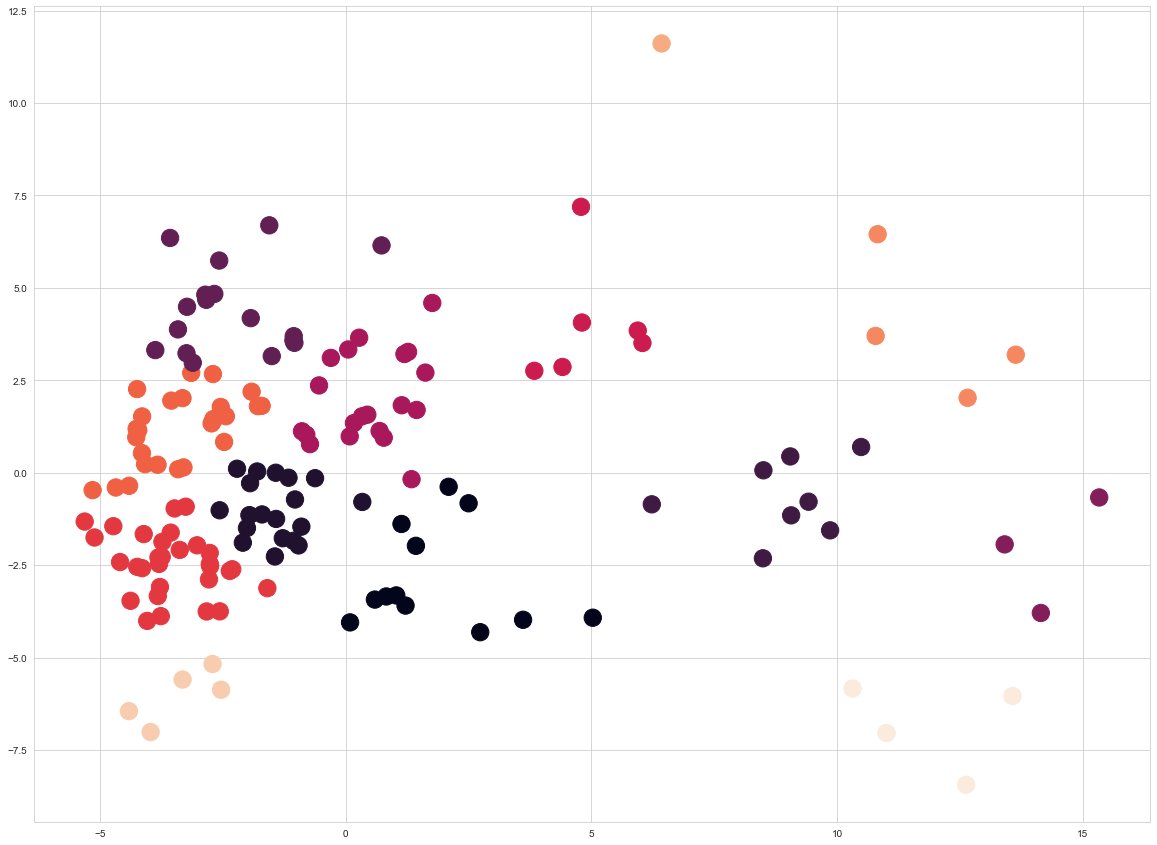

In [23]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000,random_state=1)

labels = kmeans.fit_predict(mySeries_transformed)

plt.figure(figsize=(20,15))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()


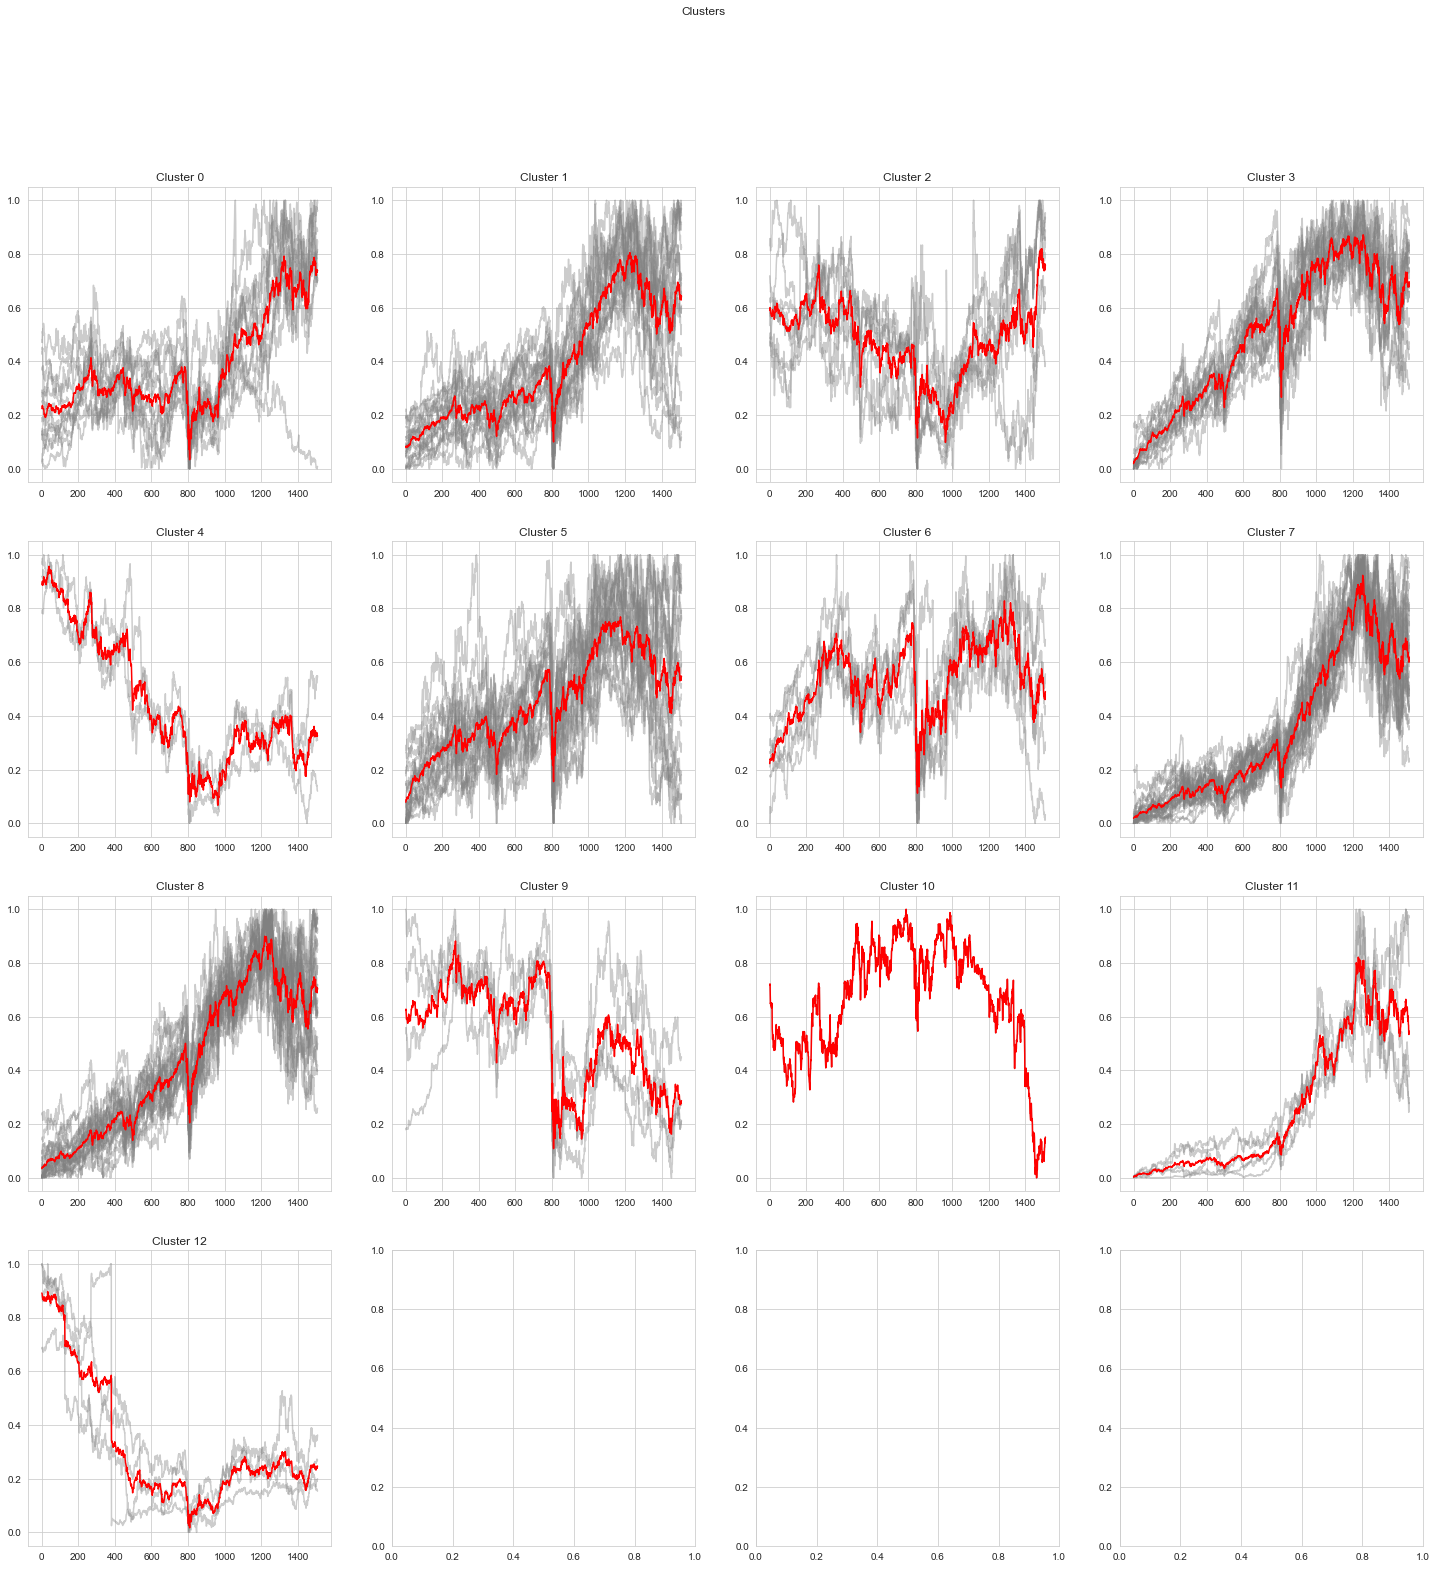

In [24]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

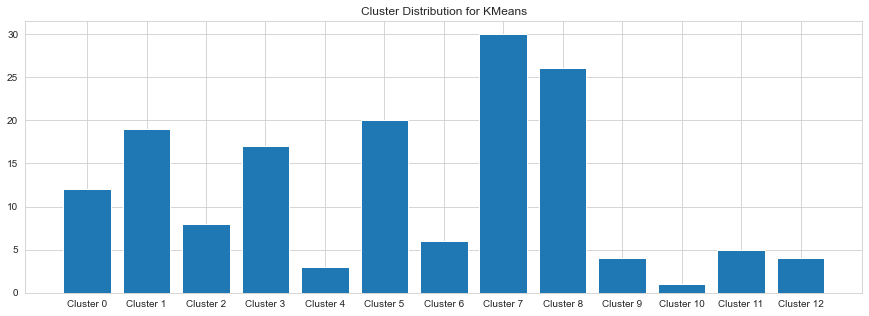

In [25]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [26]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels, [d["industry"].values[0] for d in dataOfMySeries]),
             columns=["Series","Cluster", "Industry"]).sort_values(by="Cluster").set_index("Series")

Cluster                    Industry
Series                                       
DIS     Cluster 0               Entertainment
ZS      Cluster 0     Software—Infrastructure
MRK     Cluster 0  Drug Manufacturers—General
CPRT    Cluster 0    Auto & Truck Dealerships
CVS     Cluster 0            Healthcare Plans
...           ...                         ...
UNP     Cluster 8                   Railroads
LIN     Cluster 9         Specialty Chemicals
C       Cluster 9           Banks—Diversified
WBA     Cluster 9    Pharmaceutical Retailers
PDD     Cluster 9             Internet Retail

[155 rows x 2 columns]

# ML By Industry

In [27]:
pd.DataFrame(([d["industry"].values[0] for d in dataOfMySeries]),columns=["Industry"]).groupby("Industry")["Industry"].count().sort_values(ascending=False).reset_index(name='count')



Industry  count
0                  Semiconductors     12
1      Drug Manufacturers—General     10
2            Software—Application     10
3         Software—Infrastructure      8
4                 Medical Devices      5
..                            ...    ...
57  Insurance—Property & Casualty      1
58              Insurance Brokers      1
59        Industrial Distribution      1
60  Household & Personal Products      1
61            Utilities—Renewable      1

[62 rows x 2 columns]

# Backtesting

# Comparison

# Conclusions